### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats, integrate

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [2]:
# SD: task 1
file = np.load("../../../homeworks/hw_data/hw4_data_1.npy") # SD: load in the file
voltage = file[:,0]
uncertainties = file[:,1]

mean = np.sum(voltage / uncertainties**2) / np.sum(1 / uncertainties**2)
mean_err = np.sum(1 / uncertainties**2)**(-0.5)

print(f"The mean is {mean}, and the uncertainty is {mean_err}")

The mean is 4.942118214425304, and the uncertainty is 0.43024334605205083


In [3]:
# SD: task 2
def logL(guessed_mean, data, uncert):
    '''
    Function to calculate the log-likelihood.
    -------------------------
    Args
    ----------
    guessed_mean: the value of the guessed mean for which to calculate the log-likelihood
    data: data on which this guessed mean is based
    uncert: uncertainty on the data points
    ----------
    Returns
    ----------
    logL: log-likelihood
    '''
    z_squared = np.log(2*np.pi*(np.array(uncert)**2)) + ((data - guessed_mean)/uncert)**2
    return -0.5*np.sum(z_squared)

f_logL = lambda beta: -logL(beta, voltage, uncertainties) # SD: lambda function to feed into scipy's optimize function. -ve sign because scipy minimizes when optimizing and fit gets better with larger logL values.
bestfit_mean = optimize.fmin(f_logL, 4)[0]
print(f"The best fit mean is {bestfit_mean}")

Optimization terminated successfully.
         Current function value: 16.048013
         Iterations: 15
         Function evaluations: 30
The best fit mean is 4.9420898437500025


In [4]:
# SD: task 3 + 4
def prior(x, lower, upper):
    if (x>lower) and (x<upper):
        return 1/(upper-lower) # SD: normalized prior!
    return 0

def problem1_helper(prior_func, lower=0, upper=10):
    '''
    Function I made to generalize tasks (3) and (4)- so I could then just run it with different parameters instead of copy pasting the code.
    -------------------------
    Args:
    prior_func - the prior function to be used for calculating the pdf
    lower - the lower limit for the graph's xlim, and parameter passed into prior_func (depends on the prior_func if it wants to use it or not)
    upper - the upper limit for the graph's xlim, and parameter passed into prior_func (depends on the prior_func if it wants to use it or not)
    ----------
    Returns:
    norm_pdf - the normalized pdf of the data using the given model
    evidence - the bayesian evidence of the model
    ----------
    '''
    pdf = []
    guesses = np.linspace(0, 10, 1000)
    for guess in guesses:
        pdf.append(np.exp(logL(guess, voltage, uncertainties)) * prior_func(guess, lower, upper))
    norm_pdf = pdf/integrate.trapezoid(pdf, guesses) # SD: normalizing the pdf
    plt.plot(guesses, norm_pdf)
    plt.xlabel("mean")
    plt.ylabel("posterior pdf")
    plt.title("posterior probability density")
    plt.xlim(lower-1, upper+1)
    plt.show()

    cdf = np.cumsum(norm_pdf)
    norm_cdf = cdf/cdf[-1] # SD: normalizing the cdf
    plt.plot(guesses, norm_cdf)

    lower_bound = guesses[np.where(norm_cdf<0.1585)[0][-1]] # SD: bounds for 68.3% credible region
    upper_bound = guesses[np.where(norm_cdf>0.8415)[0][0]]

    print(f"Equal-tailed 68.3% credible region: ({lower_bound}, {upper_bound})")
    print(f"(mu-sigma, mu+sigma): ({mean-mean_err}, {mean+mean_err})")

    MAP = guesses[np.where(norm_cdf>=0.5)[0][0]] # SD: MAP is in the middle of the cdf- so using it to easily get the index of the MAP
    print(f"MAP: {MAP}")

    plt.axvline(x=lower_bound, color='k', linestyle='--', label='68.3% credible region')
    plt.axvline(x=upper_bound, color='k', linestyle='--')
    plt.xlabel("mean")
    plt.ylabel("cdf")
    plt.title("CDF")
    plt.legend()
    plt.xlim(lower-1, upper+1)
    plt.show()

    return norm_pdf, integrate.trapezoid(pdf, guesses)

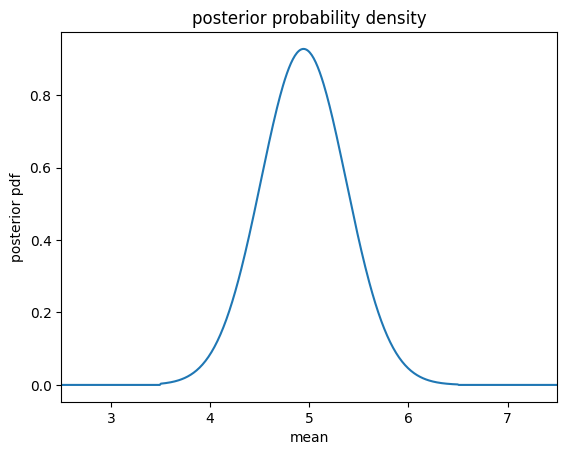

Equal-tailed 68.3% credible region: (4.504504504504505, 5.375375375375375)
(mu-sigma, mu+sigma): (4.511874868373253, 5.372361560477355)
MAP: 4.944944944944945


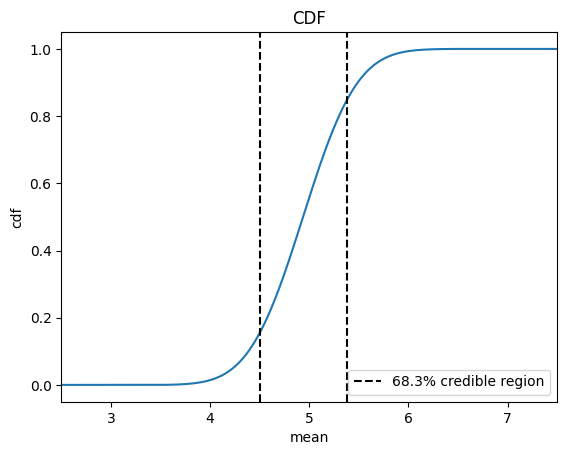

In [5]:
task3, evidence_task3 = problem1_helper(prior, 3.5, 6.5)

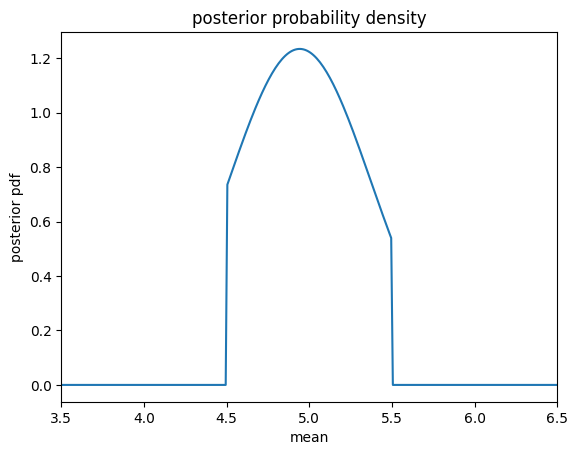

Equal-tailed 68.3% credible region: (4.664664664664665, 5.275275275275275)
(mu-sigma, mu+sigma): (4.511874868373253, 5.372361560477355)
MAP: 4.974974974974975


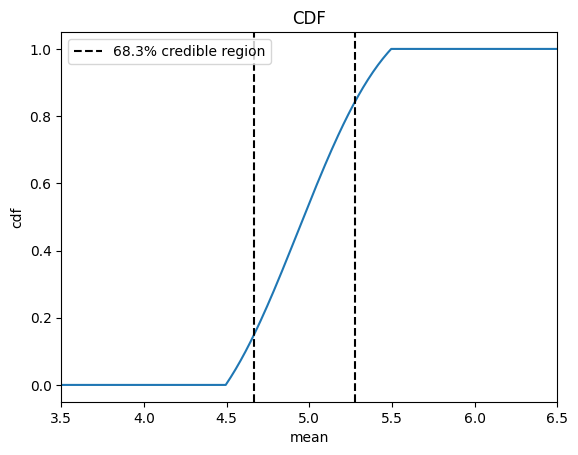

In [6]:
# SD: task 5
task5, _ = problem1_helper(prior, 4.5, 5.5) # SD: throwing the evidence away because we don't need it

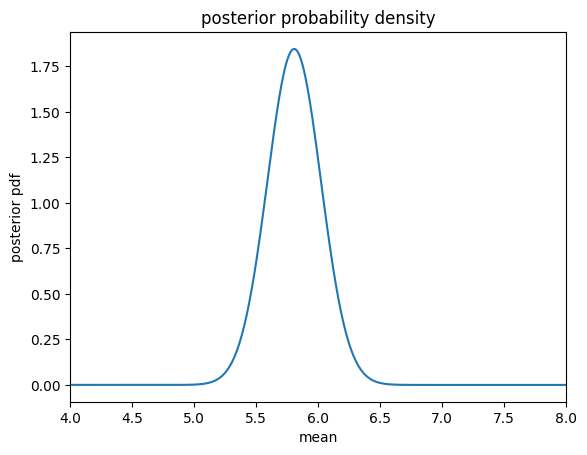

Equal-tailed 68.3% credible region: (5.585585585585585, 6.026026026026026)
(mu-sigma, mu+sigma): (4.511874868373253, 5.372361560477355)
MAP: 5.8058058058058055


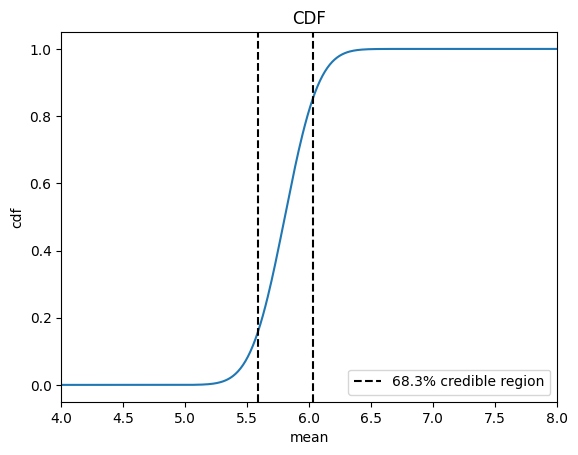

In [7]:
# SD: task 6
def gaussian_prior(x, *args): # SD: *args is there to handle the lower and upper values passed to function. values ignored as we don't need them for this prior!
    return stats.norm(6.1, 0.25).pdf(x)

task6, _ = problem1_helper(gaussian_prior, 5, 7) # SD: throwing the evidence away because we don't need it

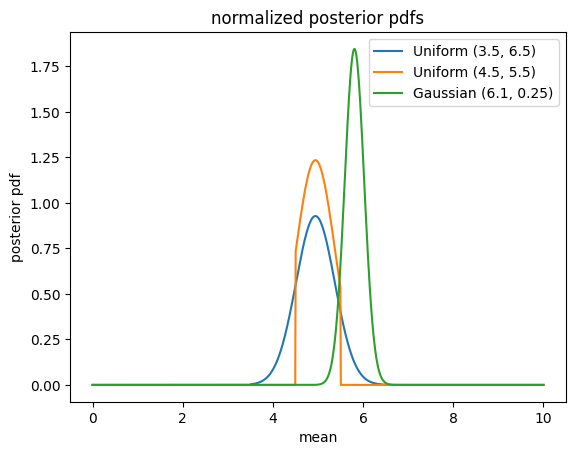

In [8]:
# SD: task 7
guesses = np.linspace(0, 10, 1000)
plt.plot(guesses, task3, label="Uniform (3.5, 6.5)")
plt.plot(guesses, task5, label="Uniform (4.5, 5.5)")
plt.plot(guesses, task6, label="Gaussian (6.1, 0.25)")
plt.legend()
plt.xlabel("mean")
plt.ylabel("posterior pdf")
plt.title("normalized posterior pdfs")
plt.show()

Due to properties of delta function, the evidence will just be equal to the likelihood at the point where the delta function is not 0.

In [9]:
# SD: task 8
print("Bayes factor =", np.exp(logL(mean, voltage, uncertainties))/evidence_task3)

Bayes factor = 2.7832496267004356


This means the delta function prior is preferred over the uniform prior. There is an Occam penalty, which is why we are preferring the simpler (1 parameter) delta function prior, but it is not too big as we are dealing with a small number of points and the uniform prior isn't super complex (has 2 parameters).

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [10]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9? 

### Solution

In [11]:
# SD: task 1
data = np.load("../../../homeworks/hw_data/hw4_data_2.npy") # SD: load in the file
x, y, sigma_y = data # SD: setting these values as per task 1... but they never get used because logL takes in 'data' not the individual values.

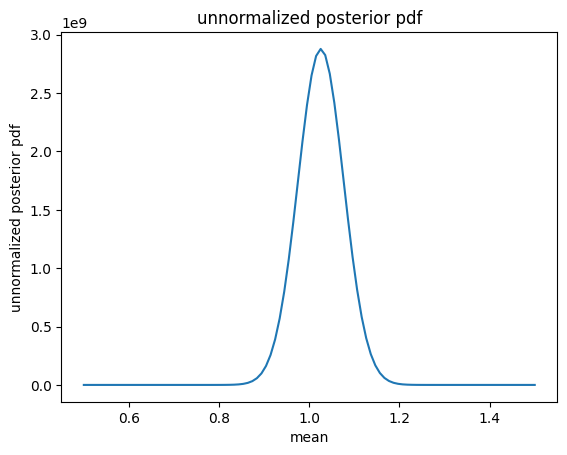

Bayesian evidence of uniform model: 365684733.16065943


In [12]:
# SD: task 2
unnormed_pdf = []
thetas = np.linspace(0.5, 1.5, 100)
for theta in thetas:
    unnormed_pdf.append(np.exp(logL([-0.23, theta], data)) * prior(theta, 0.5, 1.5)) # SD: reusing the prior function from Part 1!
plt.plot(thetas, unnormed_pdf)
plt.xlabel("mean")
plt.ylabel("unnormalized posterior pdf")
plt.title("unnormalized posterior pdf")
plt.show()

# SD: task 3
evidence_linear = integrate.trapezoid(unnormed_pdf, thetas)
print("Bayesian evidence of uniform model:", evidence_linear)

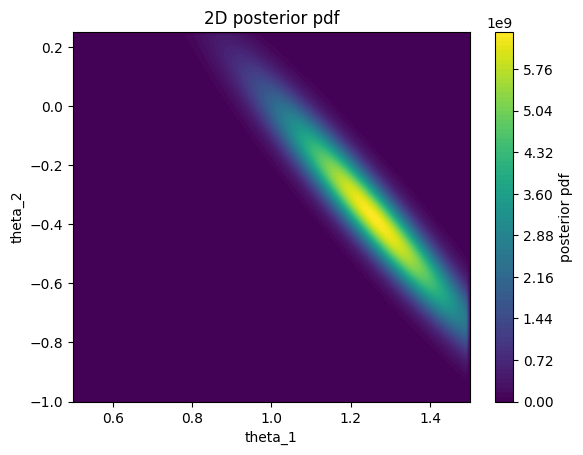

Bayesian evidence of quadratic model: 487806846.2331482
Bayes factor for quadratic/linear: 1.3339546390601869


In [ ]:
# SD: task 4
unnormed_pdf = np.zeros([100, 100])
theta_1_list = np.linspace(0.5, 1.5, 100)
theta_2_list = np.linspace(-1, 0.25, 100)
for i, theta_1 in enumerate(theta_1_list):
    for j, theta_2 in enumerate(theta_2_list):
        unnormed_pdf[j,i] = np.exp(logL([-0.23, theta_1, theta_2], data)) * prior(theta_1, 0.5, 1.5) * prior(theta_2, -1, 0.25) # SD: contourf takes Z axis values in (y,x) format! so have to store values with [j, i] instead of the usual [i, j]

t1, t2 = np.meshgrid(theta_1_list, theta_2_list)
plt.contourf(t1, t2, unnormed_pdf, levels=100)
plt.colorbar(label="posterior pdf")
plt.xlabel("theta_1")
plt.ylabel("theta_2")
plt.title("2D posterior pdf")
plt.show()

# SD: task 5 + 6
evidence_quad = integrate.trapezoid(integrate.trapezoid(unnormed_pdf, theta_2_list), theta_1_list) # SD: double integral because 2D
print("Bayesian evidence of quadratic model:", evidence_quad)
print("Bayes factor for quadratic/linear:", evidence_quad/evidence_linear)

This means there is a slight preference for the quadratic model. This is opposite of the BIC comparison in lecture 9, where we concluded that the improvement in chi_squared in the quadratic model is not big enough to justify another free parameter.